In [1]:
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import activations, layers, losses, optimizers, regularizers

In [2]:
DATAPATH = "/Users/Documents/workspacetf/GAN_Project/data/lfw"

path_lists = []
formats = ['.jpg', '.jpeg', '.JPG', '.bmp', '.png']
 
for (root, dirs, files) in os.walk(DATAPATH):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in formats:
                tmp = root + '/' + file_name
                path_lists.append(tmp)

In [ ]:
print(f'Total Image cnt : {len(path_lists)} \nFirst path : {path_lists[0]} \nSecond path : {path_lists[0]}')

In [4]:
import cv2

def image_show(path, cnt):
    fig = plt.figure()
    rows = int(cnt/3)
    cols = 3
    idx = 1

    xlabels = ["xlabel"]

    for i in range(0, cnt):
        xlabels.append(os.path.basename(path[i]))
        
        img = cv2.imread(path[i])
        ax = fig.add_subplot(rows, cols, idx)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        ax.set_xlabel(xlabels[i+1])
        ax.set_xticks([]), ax.set_yticks([])
        idx+=1

    plt.show()

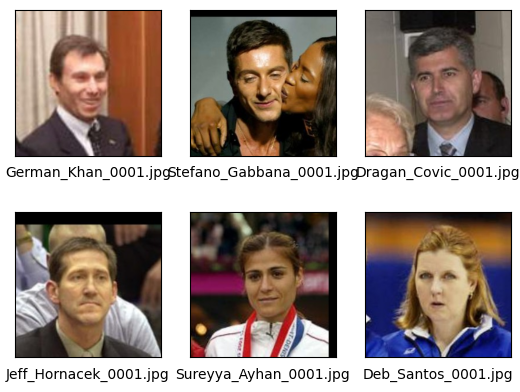

In [5]:
image_show(path_lists, 6)

In [2]:
FULL_IMAGE_DIR = '/Users/Documents/workspacetf/GAN_Project/data/lfwmv'

BATCH_SIZE = 32
IMAGE_SHAPE = (180, 180, 3)

data = tf.keras.utils.image_dataset_from_directory(
    FULL_IMAGE_DIR,
    labels=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE[:2],
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
#     interpolation='bilinear',
)

Found 13233 files belonging to 1 classes.
Metal device set to: Apple M1


2023-03-07 17:10:27.484980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 17:10:27.485088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-03-07 17:10:27.561848: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


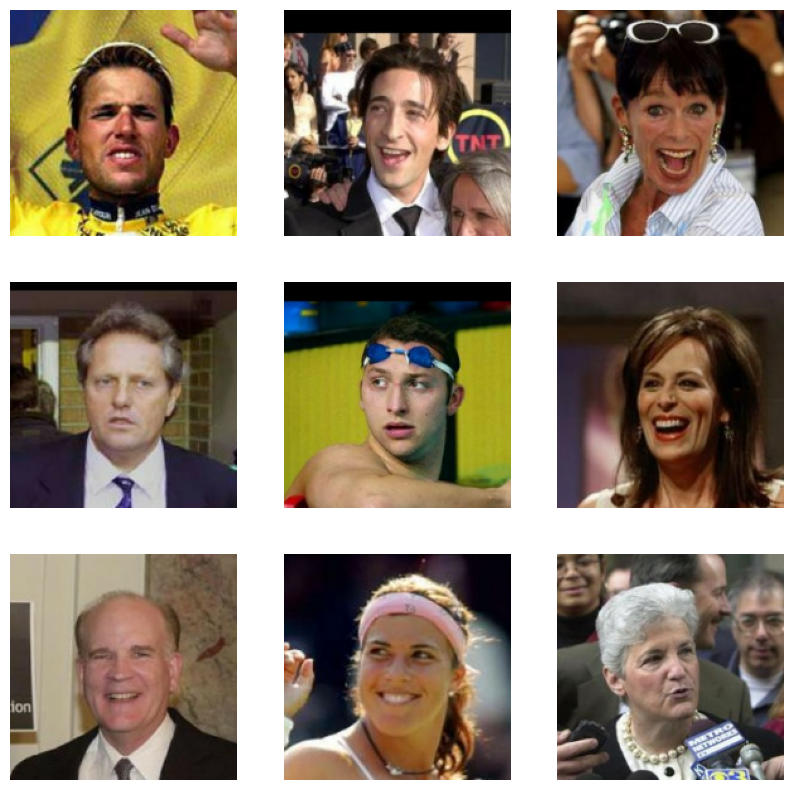

In [3]:
# 데이터셋 시각화
plt.figure(figsize=(10, 10))
for images in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [4]:
tf.keras.backend.clear_session()

In [5]:
# 생성기, 판별기 모델 생성
CODE_SIZE = 256

# 180, 180, 3 model
generator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(CODE_SIZE,), name='code'),
    tf.keras.layers.Dense(6*6*32, activation='elu'),
    tf.keras.layers.Reshape((6,6,32)),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=21, activation='elu'),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=15, activation='elu'),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=15, activation='elu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=15, activation='elu'),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=13, activation='elu'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=13, activation='elu'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=13, activation='elu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=7, activation='elu'),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=3)
    ], name="generator_model")


In [6]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SHAPE, name="image"),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='elu'),
    tf.keras.layers.Conv2D(64, kernel_size=5, activation='elu'),
    tf.keras.layers.Conv2D(64, kernel_size=5, activation='elu'),
    tf.keras.layers.Conv2D(128, kernel_size=5, activation='elu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, kernel_size=3, activation='elu'),
    tf.keras.layers.Conv2D(256, kernel_size=3, activation='elu'),
    tf.keras.layers.Conv2D(256, kernel_size=5, activation='elu'),
    tf.keras.layers.Conv2D(256, kernel_size=3, activation='elu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()),
    tf.keras.layers.Dense(1, activation='sigmoid'),
], name="discriminator_model")

In [7]:
# shape test
generator.summary()
print("Inputs :", generator.inputs)
print("Outputs:", generator.outputs)

assert generator.output_shape[1:] == IMAGE_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMAGE_SHAPE,generator.output_shape[1:])

Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              296064    
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 26, 26, 256)      3612928   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 40, 40, 256)      14745856  
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 54, 54, 256)      14745856  
 ranspose)                                                       
                                                   

In [8]:
discriminator.summary()
print("Inputs :", discriminator.inputs)
print("Outputs:", discriminator.outputs)

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 174, 174, 64)      51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 170, 170, 64)      102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 166, 166, 128)     204928    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 81, 81, 128)       147584    
                                               